# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [4]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore

dirscripts  = os.path.join(os.path.dirname(os.getcwd()), "Scripts")
sys.path.insert(0, dirscripts)

#Eigen styling importeren 
import Styling

## Utilities

In [5]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

In [23]:
# Current directory notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Path naar files
data_dir = os.path.abspath(os.path.join(notebook_dir, '..', 'data'))

# Lijs van alle files
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Lijst met juiste en foute df
dataframes = []
dfs_wrong = [] 

for file in csv_files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    #Nieuwe kolom geboortedag uit naam file 
    df['geboortedag'] = pd.to_datetime(file[:-4], format='%Y-%m-%d', errors='coerce')  
    

    # Foute datums zoeken ('2019-2-29')
    if file == '2019-2-29.csv':
        # Als hij niet al in het df staat
        if not any(df['geboortedag'].dt.strftime('%Y-%m-%d') == file[:-4]):
            # Aan df toevoegen met extra kolom 'reden'
            df['reden'] = '2019 is geen schrikkeljaar'
            dfs_wrong.append(df)
    else: dataframes.append(df)

# Concatenate dataframes
df = pd.concat(dataframes, ignore_index=True)
df_wrong = pd.concat(dfs_wrong, ignore_index=True)

In [22]:
# Convert 'verwachte datum' naar datetime
df['verwachte datum'] = pd.to_datetime(df['verwachte datum'], format='%m/%d/%Y')

In [21]:
# 'dag van het jaar' kolom voor 'verwachte datum'
df['dag_van_het_jaar_verwacht'] = df['verwachte datum'].dt.dayofyear.astype(int)

# 'dag van het jaar' kolom 'geboortedag'
df['dag_van_het_jaar_geboorte'] = df['geboortedag'].dt.dayofyear.astype(int)

## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

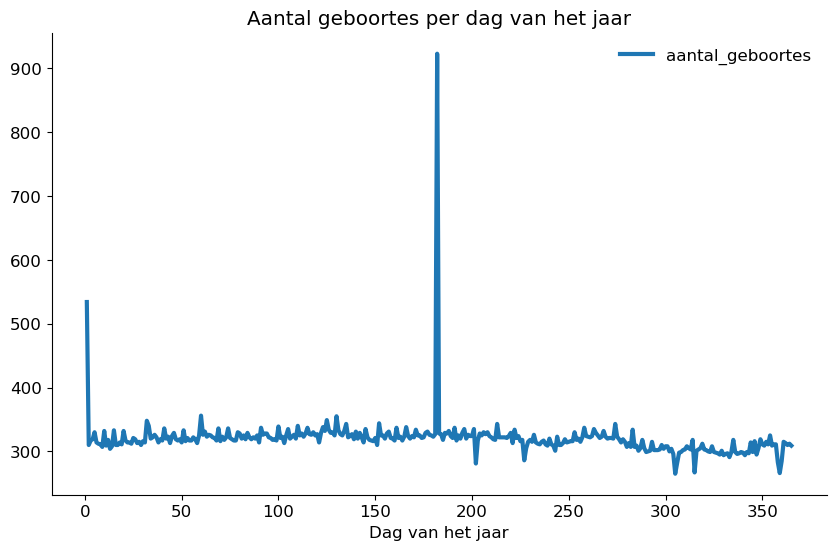

In [9]:
# Count geboorted per dag
birth_counts = df['dag_van_het_jaar_geboorte'].value_counts().sort_index()

# Line plot
plt.plot(birth_counts.index, birth_counts.values, label= 'aantal_geboortes')
plt.title('Aantal geboortes per dag van het jaar')
plt.xlabel('Dag van het jaar')
plt.legend()
plt.show()

##

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [10]:
# Counts geboortedag
births_count = df['geboortedag'].value_counts().sort_index()

# Mediaan
median_births = births_count.median()

# Thresholds zetten
threshold_upper = median_births * 1.5
threshold_lower = median_births * 0.5


outliers = births_count[(births_count > threshold_upper) | (births_count < threshold_lower)]


print(f"Outlier dates: {outliers}")

Outlier dates: geboortedag
2019-01-01    534
2019-07-01    923
Name: count, dtype: int64


Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [20]:
# Append '2019-01-01' en '2019-07-01' 
wrong_records = df[df['geboortedag'].isin([pd.Timestamp('2019-01-01'), pd.Timestamp('2019-07-01')])].copy()
wrong_records['reden'] = 'datum mogelijks niet correct genoteerd'
df_wrong = pd.concat([df_wrong, wrong_records], ignore_index=True)

# Verwijder ze uit df
cleaned_df = df[~df['geboortedag'].isin([pd.Timestamp('2019-01-01'), pd.Timestamp('2019-07-01')])]

Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

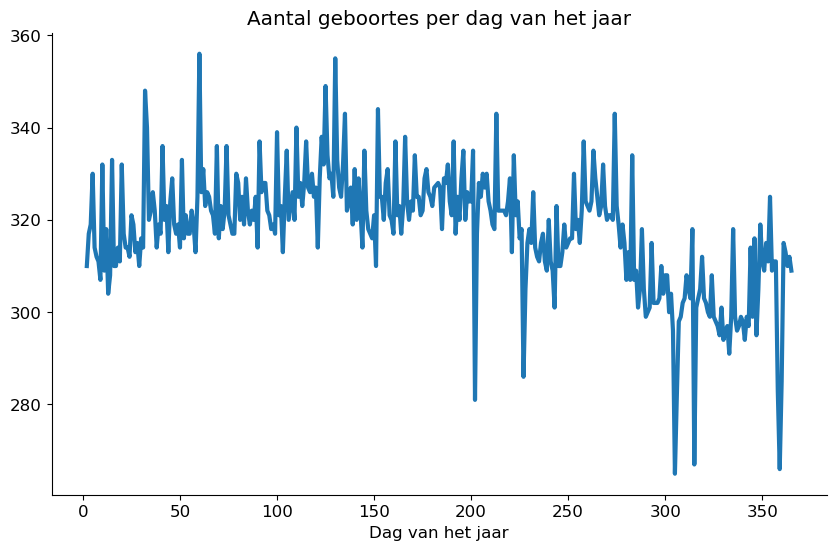

In [12]:
# Count geboorted per dag
birth_counts = cleaned_df['dag_van_het_jaar_geboorte'].value_counts().sort_index()

# Line plot
plt.plot(birth_counts.index, birth_counts.values)
plt.title('Aantal geboortes per dag van het jaar')
plt.xlabel('Dag van het jaar')
plt.show()

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [13]:
# Midden van het jaar berekenen
midpoint_date = cleaned_df['dag_van_het_jaar_geboorte'].min() + (cleaned_df['dag_van_het_jaar_geboorte'].max() - cleaned_df['dag_van_het_jaar_geboorte'].min()) / 2
birth_counts_second_half = birth_counts[birth_counts.index > midpoint_date]

# Kwartielen berekenen
Q1_second_half = birth_counts_second_half.quantile(0.25)
Q3_second_half = birth_counts_second_half.quantile(0.75)
IQR_second_half = Q3_second_half - Q1_second_half

#Treshhold voor uitschieters
threshold = 1
extreme_outliers_second_half = birth_counts_second_half[(birth_counts_second_half < (Q1_second_half - threshold * IQR_second_half)) | (birth_counts_second_half > (Q3_second_half + threshold * IQR_second_half))]

print(extreme_outliers_second_half)

dag_van_het_jaar_geboorte
202    281
213    343
274    343
305    265
306    282
315    267
358    283
359    266
Name: count, dtype: int64


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

In [24]:
#Kolom weekdag
cleaned_df.loc[:, 'weekdag'] = cleaned_df['geboortedag'].dt.strftime('%A')

In [25]:
#Kolom week van het jaar
cleaned_df.loc[:, 'week_van_het_jaar_geboorte'] = cleaned_df['geboortedag'].dt.isocalendar().week

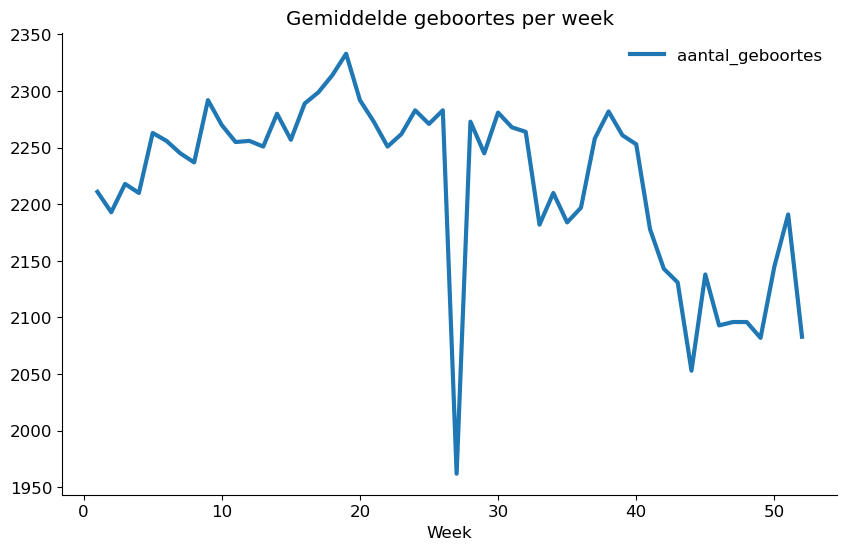

In [16]:
#Gemiddelde elke week
gemiddelde_per_week = cleaned_df.groupby('week_van_het_jaar_geboorte').size()
gemiddelde_per_week.plot(kind='line', label = 'aantal_geboortes')
plt.title('Gemiddelde geboortes per week')
plt.xlabel('Week')
plt.legend()
plt.show()

Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

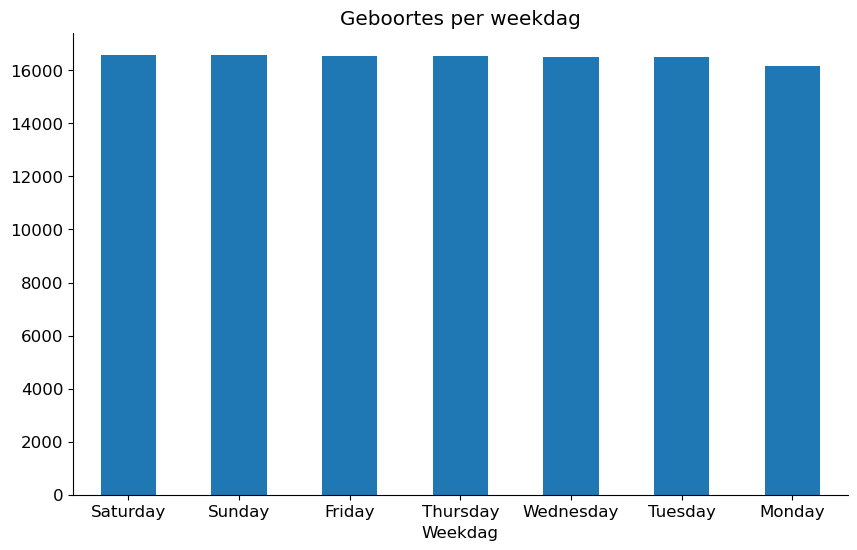

In [30]:
weekday_counts = cleaned_df['weekdag'].value_counts()

# Bar plot
weekday_counts.plot(kind='bar')
plt.title('Geboortes per weekdag')
plt.xlabel('Weekdag')
plt.xticks(rotation=0)
plt.show()